In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt

np.warnings = warnings

ROOT_DIR = Path('..')
sys.path.append(os.path.abspath(os.path.join('../Kha Huynh/Data cleansing')))
sys.path.append(os.path.abspath(os.path.join('..')))
import DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import model_evaluation as me
reload(me)

import src.modelling_pipeline as modelling_pipeline
reload(modelling_pipeline)

mp = modelling_pipeline.ModelPipeline(ROOT_DIR)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical

import tensorflow as tf

# Data Preparation - Train val test split

In [3]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/Model input data/t4_nan.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(data_df):
    x_train_df = df_data.merge(data_df[['SUBJECT_ID', 'HADM_ID']])
    x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_train_df, x_train_count, y_train_df

x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                admission['IS_SEPSIS'],
                                                test_size=0.2,
                                                )

x_train_df, x_train_count, y_train_df = create_data_df(x_train_df)
x_test_df, x_test_count, y_test_df = create_data_df(x_test_df)

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [5]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))

In [6]:
def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    mask = tf.math.is_finite(secs_data.values)
    mask = tf.RaggedTensor.from_row_lengths(mask, X_count)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels, mask


In [7]:
def data_preparation():
  train_data, act_train, mask_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test, mask_test = ts_to_secs(x_test, x_test_count, y_test_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())

  return train_data, act_train, test_data, act_test

In [8]:
x_train, y_train, x_test, y_test = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([36972    13    43], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9244   13   43], shape=(3,), dtype=int64)


# Model Definition

In [9]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

# sample_weights = mask_train
sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

# sample_weights_test = mask_test
sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [10]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

m_hist = []
models = []

# Simple LSTM

In [11]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [12]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
from keras.models import Sequential

def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model
model = LSTM_model()
models.append(model)

In [13]:
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = LSTM_model()
models.append(model)

In [14]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model
model = GRU_model()
models.append(model)

In [15]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = GRU_model()
models.append(model)

In [16]:
from sklearn.model_selection import StratifiedKFold
k = 5
fold_size = x_train.shape[0] // k
num_epochs = 10

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for i, model in enumerate(models):
  print(f"----------------Start model {i}---------------------")
  
  checkpointer = ModelCheckpoint(filepath = f'weights_best_struct_{i}.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
  callbacks_list = [lr_scheduler, checkpointer]
  model.summary()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)
  acc, val_acc, auc, val_auc, loss, val_loss= [], [], [], [], [], []
  # Loop through the k folds
  for j, (train_index, val_index) in enumerate(skf.split(x_train, y_train.argmax(1))):
    print(f'---------------------Start K={j}-------------------------------')
    
    x_train_kf, x_val_kf = tf.gather(x_train, train_index), tf.gather(x_train, val_index)
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    sample_weights = me.compute_sample_weights(y_train_kf[:,1].astype(int))

    # Train the model
    m = model.fit(x_train_kf,y_train_kf,
              sample_weight=sample_weights,
              epochs=num_epochs, batch_size=64, verbose=1,
              validation_data=(x_val_kf, y_val_kf),
              callbacks=callbacks_list)
    acc.append(m.history['accuracy'])
    val_acc.append(m.history['val_accuracy'])
    auc.append(m.history['auc'])
    val_auc.append(m.history['val_auc'])
    loss.append(m.history['loss'])
    val_loss.append(m.history['val_loss'])
  mean_acc = [sum(values) / len(values) for values in zip(*acc)]
  mean_val_acc = [sum(values) / len(values) for values in zip(*val_acc)]
  mean_auc = [sum(values) / len(values) for values in zip(*auc)]
  mean_val_auc = [sum(values) / len(values) for values in zip(*val_auc)]
  mean_loss = [sum(values) / len(values) for values in zip(*loss)]
  mean_val_loss = [sum(values) / len(values) for values in zip(*val_loss)]
  m_hist.append([mean_acc, mean_val_acc, mean_auc, mean_val_auc, mean_loss, mean_val_loss])

----------------Start model 0---------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               88064     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 88322 (345.01 KB)
Trainable params: 88322 (345.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
---------------------Start K=0-------------------------------
Epoch 1/10
463/463 [==============================] - 5s 8ms/step - loss: 0.5690 - accuracy: 0.6977 - auc: 0.7558 - val_loss: 0.5386 - val_accuracy: 0.7619 - val_auc: 0.

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 4s 9ms/step - loss: 0.5144 - accuracy: 0.7606 - auc: 0.8220 - val_loss: 0.5310 - val_accuracy: 0.7551 - val_auc: 0.8142 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 4s 8ms/step - loss: 0.4982 - accuracy: 0.7681 - auc: 0.8357 - val_loss: 0.5010 - val_accuracy: 0.7712 - val_auc: 0.8372 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 4s 8ms/step - loss: 0.4863 - accuracy: 0.7746 - auc: 0.8449 - val_loss: 0.4820 - val_accuracy: 0.7750 - val_auc: 0.8500 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4760 - accuracy: 0.7763 - auc: 0.8510 - val_loss: 0.4939 - val_accuracy: 0.7767 - val_auc: 0.8446 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4640 - accuracy: 0.7812 - auc: 0.8571 - val_loss: 0.4462 - val_accuracy: 0.8026 - val_auc: 0.8778 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 12ms/step - loss: 0.4251 - accuracy: 0.8106 - auc: 0.8836 - val_loss: 0.4107 - val_accuracy: 0.8262 - val_auc: 0.8932 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4114 - accuracy: 0.8175 - auc: 0.8904 - val_loss: 0.4074 - val_accuracy: 0.8203 - val_auc: 0.8952 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 12ms/step - loss: 0.4031 - accuracy: 0.8206 - auc: 0.8947 - val_loss: 0.4307 - val_accuracy: 0.8051 - val_auc: 0.8811 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 5s 12ms/step - loss: 0.3963 - accuracy: 0.8244 - auc: 0.8983 - val_loss: 0.4147 - val_accuracy: 0.8180 - val_auc: 0.8914 - lr: 5.4881e-04
Epoch 8/10
463/463 [==============================] - 5s 11ms/step - loss: 0.3843 - accuracy: 0.8325 - auc: 0.9058 - val_loss: 0.4265 - val_accuracy: 0.8151 - val_auc: 0.8865 - lr: 4.9659e-04
Epoch 9/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.3959 - accuracy: 0.8261 - auc: 0.8997 - val_loss: 0.4134 - val_accuracy: 0.8147 - val_auc: 0.8895 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3864 - accuracy: 0.8324 - auc: 0.9056 - val_loss: 0.3803 - val_accuracy: 0.8327 - val_auc: 0.9084 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3707 - accuracy: 0.8364 - auc: 0.9100 - val_loss: 0.3788 - val_accuracy: 0.8346 - val_auc: 0.9091 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3590 - accuracy: 0.8410 - auc: 0.9158 - val_loss: 0.3908 - val_accuracy: 0.8311 - val_auc: 0.9039 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 11ms/step - loss: 0.3483 - accuracy: 0.8487 - auc: 0.9220 - val_loss: 0.3450 - val_accuracy: 0.8554 - val_auc: 0.9254 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.3459 - accuracy: 0.8507 - auc: 0.9233 - val_loss: 0.3623 - val_accuracy: 0.8449 - val_auc: 0.9195 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3347 - accuracy: 0.8546 - auc: 0.9265 - val_loss: 0.3204 - val_accuracy: 0.8662 - val_auc: 0.9354 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3336 - accuracy: 0.8557 - auc: 0.9274 - val_loss: 0.3312 - val_accuracy: 0.8634 - val_auc: 0.9333 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3196 - accuracy: 0.8627 - auc: 0.9341 - val_loss: 0.3626 - val_accuracy: 0.8503 - val_auc: 0.9189 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3070 - accuracy: 0.8683 - auc: 0.9375 - val_loss: 0.3201 - val_accuracy: 0.8718 - val_auc: 0.9374 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 11ms/step - loss: 0.2987 - accuracy: 0.8738 - auc: 0.9426 - val_loss: 0.2948 - val_accuracy: 0.8758 - val_auc: 0.9459 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 5s 10ms/step - loss: 0.2818 - accuracy: 0.8801 - auc: 0.9481 - val_loss: 0.2930 - val_accuracy: 0.8773 - val_auc: 0.9453 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 11ms/step - loss: 0.2664 - accuracy: 0.8860 - auc: 0.9522 - val_loss: 0.2795 - val_accuracy: 0.8830 - val_auc: 0.9494 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 5s 11ms/step - loss: 0.2675 - accuracy: 0.8892 - auc: 0.9533 - val_loss: 0.2811 - val_accuracy: 0.8821 - val_auc: 0.9494 - lr: 5.4881e-04
Epoch 8/10
463/463 [==============================] - 5s 10ms/step - loss: 0.2544 - accuracy: 0.8959 - auc: 0.9572 - val_loss: 0.2926 - val_accuracy: 0.8806 - val_auc: 0.9461 - lr: 4.9659e-04
Epoch 9/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 11ms/step - loss: 0.5131 - accuracy: 0.7630 - auc: 0.8224 - val_loss: 0.5419 - val_accuracy: 0.7568 - val_auc: 0.8086 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 5s 10ms/step - loss: 0.5010 - accuracy: 0.7669 - auc: 0.8329 - val_loss: 0.5338 - val_accuracy: 0.7527 - val_auc: 0.8139 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4865 - accuracy: 0.7772 - auc: 0.8465 - val_loss: 0.5255 - val_accuracy: 0.7495 - val_auc: 0.8158 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 5s 12ms/step - loss: 0.4749 - accuracy: 0.7762 - auc: 0.8476 - val_loss: 0.4866 - val_accuracy: 0.7744 - val_auc: 0.8473 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4618 - accuracy: 0.7837 - auc: 0.8598 - val_loss: 0.4714 - val_accuracy: 0.7816 - val_auc: 0.8578 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.4127 - accuracy: 0.8156 - auc: 0.8901 - val_loss: 0.4250 - val_accuracy: 0.8105 - val_auc: 0.8859 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 13ms/step - loss: 0.4055 - accuracy: 0.8199 - auc: 0.8949 - val_loss: 0.4470 - val_accuracy: 0.7997 - val_auc: 0.8747 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3922 - accuracy: 0.8235 - auc: 0.8992 - val_loss: 0.4202 - val_accuracy: 0.8147 - val_auc: 0.8913 - lr: 5.4881e-04
Epoch 8/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3979 - accuracy: 0.8230 - auc: 0.9003 - val_loss: 0.4416 - val_accuracy: 0.8051 - val_auc: 0.8791 - lr: 4.9659e-04
Epoch 9/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3794 - accuracy: 0.8330 - auc: 0.9078 - val_loss: 0.4484 - val_accuracy: 0.8064 - val_auc: 0.8787 - lr: 4.4933e-04
Epoch 10/10
463/463 [==============================

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.3931 - accuracy: 0.8258 - auc: 0.9025 - val_loss: 0.3638 - val_accuracy: 0.8412 - val_auc: 0.9175 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3798 - accuracy: 0.8284 - auc: 0.9057 - val_loss: 0.3652 - val_accuracy: 0.8407 - val_auc: 0.9175 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3681 - accuracy: 0.8331 - auc: 0.9122 - val_loss: 0.3558 - val_accuracy: 0.8465 - val_auc: 0.9219 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 7s 14ms/step - loss: 0.3544 - accuracy: 0.8442 - auc: 0.9200 - val_loss: 0.3598 - val_accuracy: 0.8451 - val_auc: 0.9194 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3476 - accuracy: 0.8444 - auc: 0.9211 - val_loss: 0.3732 - val_accuracy: 0.8404 - val_auc: 0.9144 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.3384 - accuracy: 0.8492 - auc: 0.9263 - val_loss: 0.3177 - val_accuracy: 0.8643 - val_auc: 0.9384 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3314 - accuracy: 0.8562 - auc: 0.9322 - val_loss: 0.3078 - val_accuracy: 0.8671 - val_auc: 0.9426 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3227 - accuracy: 0.8596 - auc: 0.9351 - val_loss: 0.3442 - val_accuracy: 0.8563 - val_auc: 0.9318 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3108 - accuracy: 0.8672 - auc: 0.9395 - val_loss: 0.3182 - val_accuracy: 0.8650 - val_auc: 0.9388 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3020 - accuracy: 0.8704 - auc: 0.9426 - val_loss: 0.2977 - val_accuracy: 0.8791 - val_auc: 0.9472 - lr: 5.4881e-04
Epoch 8/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.3209 - accuracy: 0.8647 - auc: 0.9361 - val_loss: 0.2465 - val_accuracy: 0.9016 - val_auc: 0.9653 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 6s 13ms/step - loss: 0.3007 - accuracy: 0.8758 - auc: 0.9447 - val_loss: 0.2949 - val_accuracy: 0.8802 - val_auc: 0.9502 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3023 - accuracy: 0.8766 - auc: 0.9467 - val_loss: 0.2913 - val_accuracy: 0.8796 - val_auc: 0.9486 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 6s 13ms/step - loss: 0.2826 - accuracy: 0.8823 - auc: 0.9502 - val_loss: 0.2710 - val_accuracy: 0.8923 - val_auc: 0.9562 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 13ms/step - loss: 0.2761 - accuracy: 0.8872 - auc: 0.9534 - val_loss: 0.2830 - val_accuracy: 0.8854 - val_auc: 0.9522 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 10ms/step - loss: 0.5115 - accuracy: 0.7622 - auc: 0.8257 - val_loss: 0.5011 - val_accuracy: 0.7693 - val_auc: 0.8381 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4964 - accuracy: 0.7667 - auc: 0.8363 - val_loss: 0.4772 - val_accuracy: 0.7817 - val_auc: 0.8542 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4857 - accuracy: 0.7770 - auc: 0.8451 - val_loss: 0.5132 - val_accuracy: 0.7623 - val_auc: 0.8298 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4752 - accuracy: 0.7809 - auc: 0.8543 - val_loss: 0.5055 - val_accuracy: 0.7634 - val_auc: 0.8346 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 10ms/step - loss: 0.4650 - accuracy: 0.7811 - auc: 0.8570 - val_loss: 0.4777 - val_accuracy: 0.7846 - val_auc: 0.8547 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 11ms/step - loss: 0.4471 - accuracy: 0.7986 - auc: 0.8711 - val_loss: 0.4211 - val_accuracy: 0.8084 - val_auc: 0.8874 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4373 - accuracy: 0.8031 - auc: 0.8764 - val_loss: 0.4443 - val_accuracy: 0.7888 - val_auc: 0.8709 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4274 - accuracy: 0.8069 - auc: 0.8823 - val_loss: 0.4308 - val_accuracy: 0.8022 - val_auc: 0.8808 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4152 - accuracy: 0.8132 - auc: 0.8886 - val_loss: 0.4468 - val_accuracy: 0.7926 - val_auc: 0.8716 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 11ms/step - loss: 0.4016 - accuracy: 0.8180 - auc: 0.8945 - val_loss: 0.4308 - val_accuracy: 0.8035 - val_auc: 0.8813 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 12ms/step - loss: 0.3923 - accuracy: 0.8216 - auc: 0.8992 - val_loss: 0.3828 - val_accuracy: 0.8274 - val_auc: 0.9069 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3781 - accuracy: 0.8284 - auc: 0.9064 - val_loss: 0.3750 - val_accuracy: 0.8335 - val_auc: 0.9110 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3623 - accuracy: 0.8346 - auc: 0.9110 - val_loss: 0.3474 - val_accuracy: 0.8469 - val_auc: 0.9239 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3560 - accuracy: 0.8412 - auc: 0.9171 - val_loss: 0.3756 - val_accuracy: 0.8303 - val_auc: 0.9100 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3473 - accuracy: 0.8434 - auc: 0.9194 - val_loss: 0.3753 - val_accuracy: 0.8342 - val_auc: 0.9112 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.3173 - accuracy: 0.8605 - auc: 0.9341 - val_loss: 0.3357 - val_accuracy: 0.8510 - val_auc: 0.9276 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3070 - accuracy: 0.8636 - auc: 0.9361 - val_loss: 0.3313 - val_accuracy: 0.8587 - val_auc: 0.9302 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3012 - accuracy: 0.8684 - auc: 0.9384 - val_loss: 0.3125 - val_accuracy: 0.8666 - val_auc: 0.9375 - lr: 5.4881e-04
Epoch 8/10
463/463 [==============================] - 6s 12ms/step - loss: 0.2927 - accuracy: 0.8730 - auc: 0.9431 - val_loss: 0.3094 - val_accuracy: 0.8684 - val_auc: 0.9401 - lr: 4.9659e-04
Epoch 9/10
463/463 [==============================] - 6s 12ms/step - loss: 0.2940 - accuracy: 0.8761 - auc: 0.9451 - val_loss: 0.3204 - val_accuracy: 0.8637 - val_auc: 0.9338 - lr: 4.4933e-04
Epoch 10/10
463/463 [==============================

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.3028 - accuracy: 0.8672 - auc: 0.9390 - val_loss: 0.2692 - val_accuracy: 0.8867 - val_auc: 0.9542 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 12ms/step - loss: 0.2941 - accuracy: 0.8725 - auc: 0.9419 - val_loss: 0.2785 - val_accuracy: 0.8826 - val_auc: 0.9494 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 6s 13ms/step - loss: 0.2845 - accuracy: 0.8763 - auc: 0.9448 - val_loss: 0.2759 - val_accuracy: 0.8815 - val_auc: 0.9501 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 12ms/step - loss: 0.2757 - accuracy: 0.8811 - auc: 0.9474 - val_loss: 0.2666 - val_accuracy: 0.8853 - val_auc: 0.9537 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 6s 12ms/step - loss: 0.2634 - accuracy: 0.8868 - auc: 0.9523 - val_loss: 0.2677 - val_accuracy: 0.8888 - val_auc: 0.9530 - lr: 5.4881e-04
Epoch 8/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 11ms/step - loss: 0.5132 - accuracy: 0.7613 - auc: 0.8241 - val_loss: 0.4757 - val_accuracy: 0.7817 - val_auc: 0.8558 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 5s 10ms/step - loss: 0.4980 - accuracy: 0.7673 - auc: 0.8353 - val_loss: 0.4735 - val_accuracy: 0.7850 - val_auc: 0.8581 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 5s 10ms/step - loss: 0.4855 - accuracy: 0.7732 - auc: 0.8452 - val_loss: 0.5159 - val_accuracy: 0.7521 - val_auc: 0.8251 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 5s 10ms/step - loss: 0.4717 - accuracy: 0.7803 - auc: 0.8546 - val_loss: 0.4962 - val_accuracy: 0.7654 - val_auc: 0.8406 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 10ms/step - loss: 0.4636 - accuracy: 0.7823 - auc: 0.8586 - val_loss: 0.4886 - val_accuracy: 0.7748 - val_auc: 0.8475 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.4480 - accuracy: 0.7896 - auc: 0.8683 - val_loss: 0.4516 - val_accuracy: 0.7932 - val_auc: 0.8698 - lr: 9.0484e-04
Epoch 3/10
463/463 [==============================] - 6s 12ms/step - loss: 0.4362 - accuracy: 0.7999 - auc: 0.8774 - val_loss: 0.3972 - val_accuracy: 0.8186 - val_auc: 0.9004 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 12ms/step - loss: 0.4222 - accuracy: 0.8052 - auc: 0.8848 - val_loss: 0.4509 - val_accuracy: 0.7976 - val_auc: 0.8721 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 6s 12ms/step - loss: 0.4125 - accuracy: 0.8096 - auc: 0.8892 - val_loss: 0.3907 - val_accuracy: 0.8262 - val_auc: 0.9045 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 6s 12ms/step - loss: 0.4040 - accuracy: 0.8159 - auc: 0.8945 - val_loss: 0.4227 - val_accuracy: 0.8119 - val_auc: 0.8887 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.3802 - accuracy: 0.8246 - auc: 0.9051 - val_loss: 0.3953 - val_accuracy: 0.8206 - val_auc: 0.9012 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3715 - accuracy: 0.8290 - auc: 0.9105 - val_loss: 0.3849 - val_accuracy: 0.8255 - val_auc: 0.9072 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3548 - accuracy: 0.8395 - auc: 0.9196 - val_loss: 0.4080 - val_accuracy: 0.8240 - val_auc: 0.8985 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 12ms/step - loss: 0.3474 - accuracy: 0.8431 - auc: 0.9228 - val_loss: 0.4016 - val_accuracy: 0.8228 - val_auc: 0.9009 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 5s 11ms/step - loss: 0.3336 - accuracy: 0.8494 - auc: 0.9280 - val_loss: 0.3691 - val_accuracy: 0.8369 - val_auc: 0.9166 - lr: 5.4881e-04
Epoch 8/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 12ms/step - loss: 0.3364 - accuracy: 0.8457 - auc: 0.9272 - val_loss: 0.2945 - val_accuracy: 0.8718 - val_auc: 0.9467 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 6s 12ms/step - loss: 0.3223 - accuracy: 0.8563 - auc: 0.9345 - val_loss: 0.3183 - val_accuracy: 0.8591 - val_auc: 0.9374 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 5s 11ms/step - loss: 0.3167 - accuracy: 0.8597 - auc: 0.9369 - val_loss: 0.3200 - val_accuracy: 0.8601 - val_auc: 0.9368 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 11ms/step - loss: 0.3041 - accuracy: 0.8644 - auc: 0.9406 - val_loss: 0.3053 - val_accuracy: 0.8691 - val_auc: 0.9437 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 5s 11ms/step - loss: 0.2994 - accuracy: 0.8697 - auc: 0.9450 - val_loss: 0.3392 - val_accuracy: 0.8535 - val_auc: 0.9305 - lr: 5.4881e-04
Epoch 8/10
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 11ms/step - loss: 0.3062 - accuracy: 0.8657 - auc: 0.9408 - val_loss: 0.3056 - val_accuracy: 0.8658 - val_auc: 0.9425 - lr: 8.1873e-04
Epoch 4/10
463/463 [==============================] - 5s 11ms/step - loss: 0.2936 - accuracy: 0.8690 - auc: 0.9445 - val_loss: 0.2865 - val_accuracy: 0.8729 - val_auc: 0.9491 - lr: 7.4082e-04
Epoch 5/10
463/463 [==============================] - 5s 11ms/step - loss: 0.2799 - accuracy: 0.8755 - auc: 0.9497 - val_loss: 0.2826 - val_accuracy: 0.8763 - val_auc: 0.9510 - lr: 6.7032e-04
Epoch 6/10
463/463 [==============================] - 5s 11ms/step - loss: 0.2735 - accuracy: 0.8799 - auc: 0.9528 - val_loss: 0.2734 - val_accuracy: 0.8820 - val_auc: 0.9543 - lr: 6.0653e-04
Epoch 7/10
463/463 [==============================] - 5s 12ms/step - loss: 0.2643 - accuracy: 0.8854 - auc: 0.9557 - val_loss: 0.3021 - val_accuracy: 0.8727 - val_auc: 0.9451 - lr: 5.4881e-04
Epoch 8/10
463/463 [==============================]

In [26]:
len(m_hist)

4

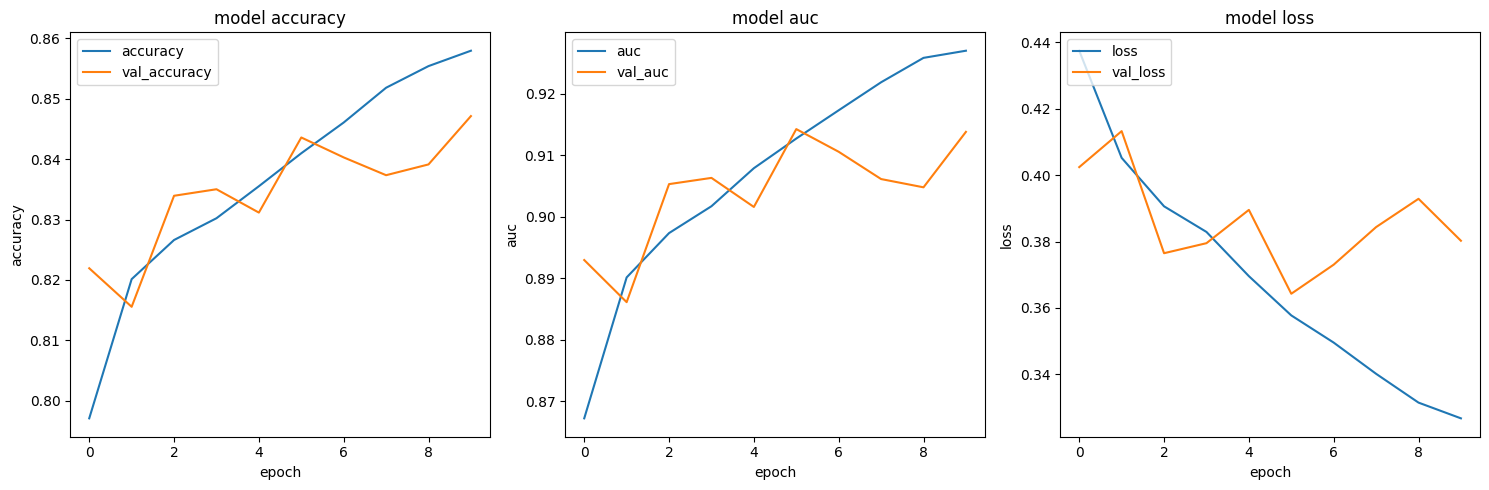

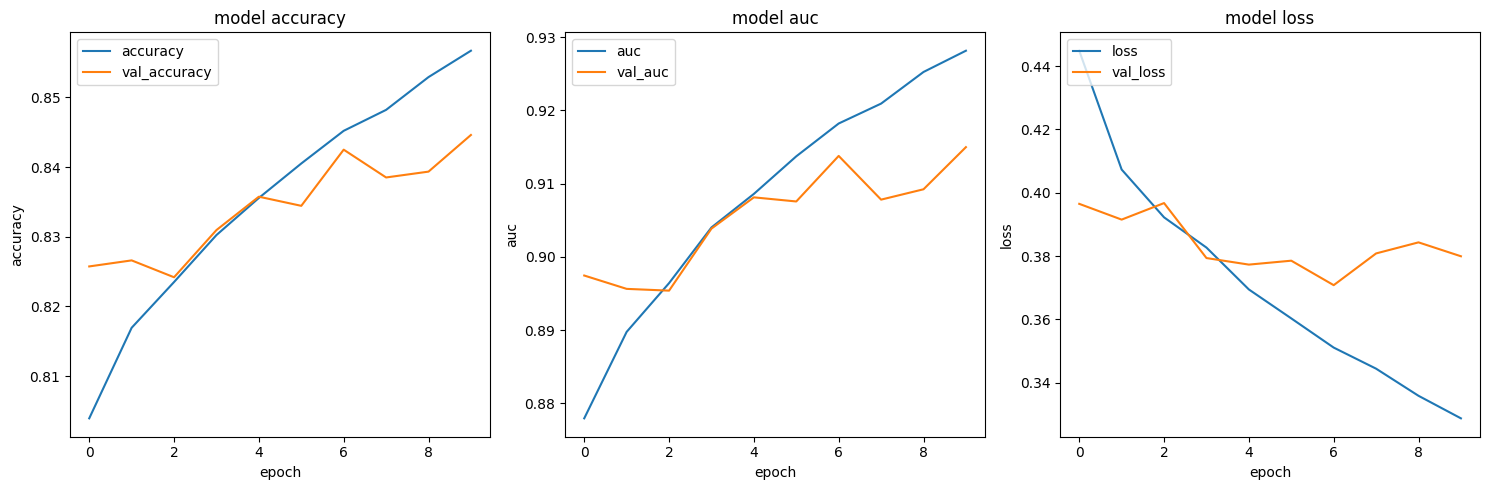

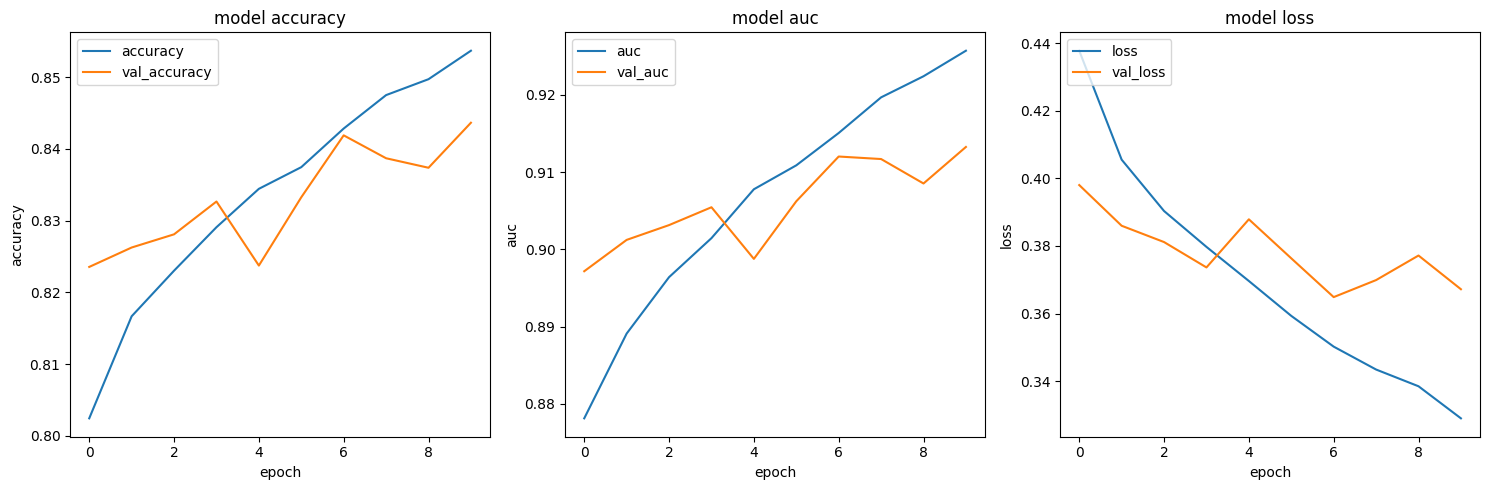

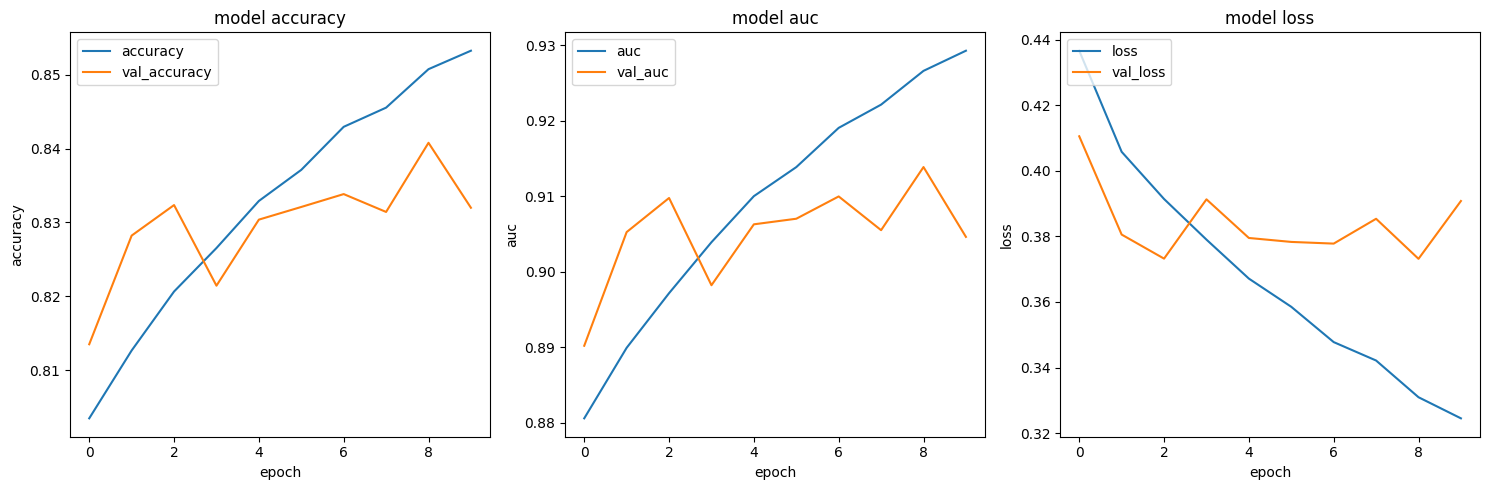

In [27]:
import matplotlib.pyplot as plt

for i, _ in enumerate(m_hist):
  # Create a figure with two subplots side by side
  fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

  # plt.plot(m.history['loss'])
  plt1.plot(m_hist[i][0])
  plt1.plot(m_hist[i][1])
  plt1.set_title('model accuracy')
  plt1.set_ylabel('accuracy')
  plt1.set_xlabel('epoch')
  plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt2.plot(m_hist[i][2])
  plt2.plot(m_hist[i][3])
  plt2.set_title('model auc')
  plt2.set_ylabel('auc')
  plt2.set_xlabel('epoch')
  plt2.legend(['auc', 'val_auc'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt3.plot(m_hist[i][4])
  plt3.plot(m_hist[i][5])
  plt3.set_title('model loss')
  plt3.set_ylabel('loss')
  plt3.set_xlabel('epoch')
  plt3.legend(['loss', 'val_loss'], loc='upper left')

  plt.tight_layout()
  plt.show()

In [36]:
len(m_hist[0][5])

10

1
3
5


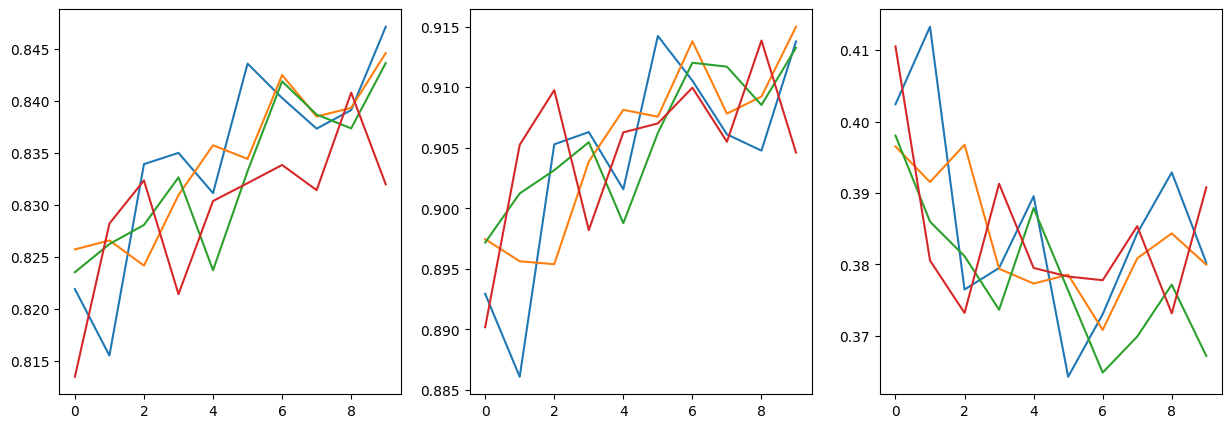

In [39]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
plts = [plt1, plt2, plt3]

for i, chart in enumerate(range(0, 5, 2)):
  plts[i].plot(m_hist[0][chart+1])
  plts[i].plot(m_hist[1][chart+1])
  plts[i].plot(m_hist[2][chart+1])
  plts[i].plot(m_hist[3][chart+1])
  # plts[i].legend([f"lstm softmax val_acc", f"lstm sigmoid val_auc", f"gru softmax val_loss", f"gru sigmoid {chart_type}"], loc="lower right")

Inference:
Inference:
Inference:
Inference:
289/289 [==============================] - 1s 3ms/step


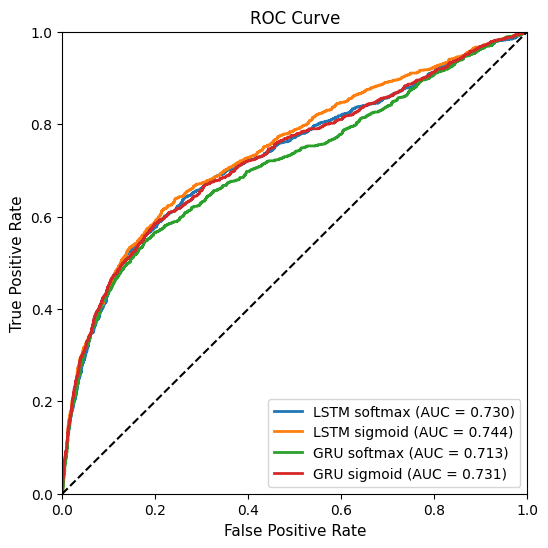

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
0,LSTM softmax,0.887617,0.689740,0.513263,0.304678,0.875346,0.523618,0.647097,0.385213
1,LSTM sigmoid,0.879850,0.685852,0.536140,0.325627,0.848203,0.495477,0.656998,0.392985
2,GRU softmax,0.899375,0.675767,0.560613,0.319106,0.882131,0.473367,0.685547,0.381222
3,GRU sigmoid,0.896799,0.684122,0.545794,0.313405,0.882131,0.500503,0.674352,0.385449


In [40]:
from keras.models import load_model
reload(me)

trained_models = {}
model_names = ['LSTM softmax', 'LSTM sigmoid', 'GRU softmax', 'GRU sigmoid']
for i, m in enumerate(model_names):
  print("Inference:")
  model = load_model(f"weights_best_struct_{i}.hdf5")
  model.optimizer.lr.numpy()
  trained_models[m] = model

me.plot_combined_roc_curves(trained_models, x_train, y_train, x_test, y_test)
# me.print_results(model, x_train, y_train, x_test, y_test)